In [88]:
import sys
sys.path.append('../')
import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.pure_fit_model as pure_fit_model

import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

#1*0.99*0.99
ps0=  torch.tensor([[0.60, 0.40, 0, 0],
                    [0, 0.60, 0.40, 0],
                    [0, 0, 0.95, 0.05],
                    [0, 0, 0.00, 1.00]], device=device)
Ts=  torch.tensor([100, 400, 600], device=device)
psMtrices= torch.stack([ps0, ps0, ps0])
crossImmMatrix= torch.tensor([[0, 0.1, 0.1],
                              [0.1, 0, 0.1],
                              [0.1, 0.1, 0]], device=device)
controlMask= torch.tensor([ [0, 1, 1, 1],
                            [1, 0, 1, 1],
                            [1, 1, 0, 1],
                            [1, 1, 1, 0]], device=device)
controlI= torch.stack([1-controlMask, 1-controlMask, 1-controlMask])
controlI= controlI[None, ...]

def load_linear(psMtrices, crossImmMatrix, device= device):
    tKn= psMtrices.shape[0]
    ts= 4
    Linear= torch.ones(tKn, tKn, 1, ts, ts, ts, device=device)
    for i in range(tKn): # k layer
        for j in range(tKn):# prod layer
            if i==j: #load paMatrices
                for k in range(ts):
                    Linear[j, i, 0, :, :, k]= psMtrices[i, ...].T
            else: #load crossImmMatrix
                Linear[j, i, 0, 1, 0, 2:4]= crossImmMatrix[j, i]
    return Linear[None, ...]

In [116]:
n= 1000
avgDegree= 6
timeHorizon= 1000
Kn= 3
#3* 3, 16*4
linear= load_linear(psMtrices, crossImmMatrix, device=device)

state= torch.zeros([1, Kn, n, 4, 1], device=device)# 3,1000,4,1
state[0, :, :, 0, 0]= 1

for i in range(Kn):
    firstInfected= random.randint(0, n-1)
    state[0, i, firstInfected, 2, 0]= 1 #go to hidden layer
    state[0, i, firstInfected, 0, 0]= 0
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
contact= contact[None, None, ...]
mySig = torch.nn.Sigmoid()
#print(state.sum(dim= 1))

In [117]:
#
stateHistory=[]
staticSI=[]
Ts=  torch.tensor([100, 400, 600], device=device)
Ts= Ts[None, ...]
for i in range(timeHorizon):
    t= torch.tensor(i, dtype=torch.float32, device=device)
    t= torch.stack([t])
    t= t[..., None]
    cL= mySig(1000*(t-Ts))
    cL= cL[..., None, None]
    cL= cL*controlMask+controlI
    cL= cL[:, None, :, None, ..., None]
    Linear= linear*cL
    A= Linear.matmul(state[:, :, None, :, None, ...])
    Psts= torch.prod(A, dim=1)
    Psts= Psts.squeeze(dim=-1)
    sumPsts= Psts.sum(dim=-2)+ 1e-8
    sumPsts= sumPsts[:, :, :,None, :]
    Psts= Psts/sumPsts
    Psts2= Psts[:, :, :, 1, 0]
    s= state[:, :, :, 0:1, 0]
    i= state[:, :, :, 2:3, 0]
    s= s.permute(0, 1, 3, 2)
    Temp= contact*i*s
    Psts2= 1-Temp*Psts2 [..., None]
    Psts2= 1-torch.prod(Psts2, dim=-2)
    Psts[:, :, :, 1, 0]= Psts2
    Psts[:, :, :, 0, 0]= 1- Psts2
    state= Psts.matmul(state)
    stateHistory.append(state.sum(dim=2).squeeze())
    prob0= 1-state[0, 0, :, 2, 0]
    prob1= 1-state[0, 1, :, 2, 0]
    prob2= 1-state[0, 2, :, 2, 0]
    statisticI= 1-prob0*prob1*prob2
    staticSI.append(statisticI.sum().item())
stateHistory= torch.stack(stateHistory)
stateHistoryPlot= stateHistory.cpu().detach()
print(state.shape)

torch.Size([1, 3, 1000, 4, 1])


torch.Size([1000])
1000


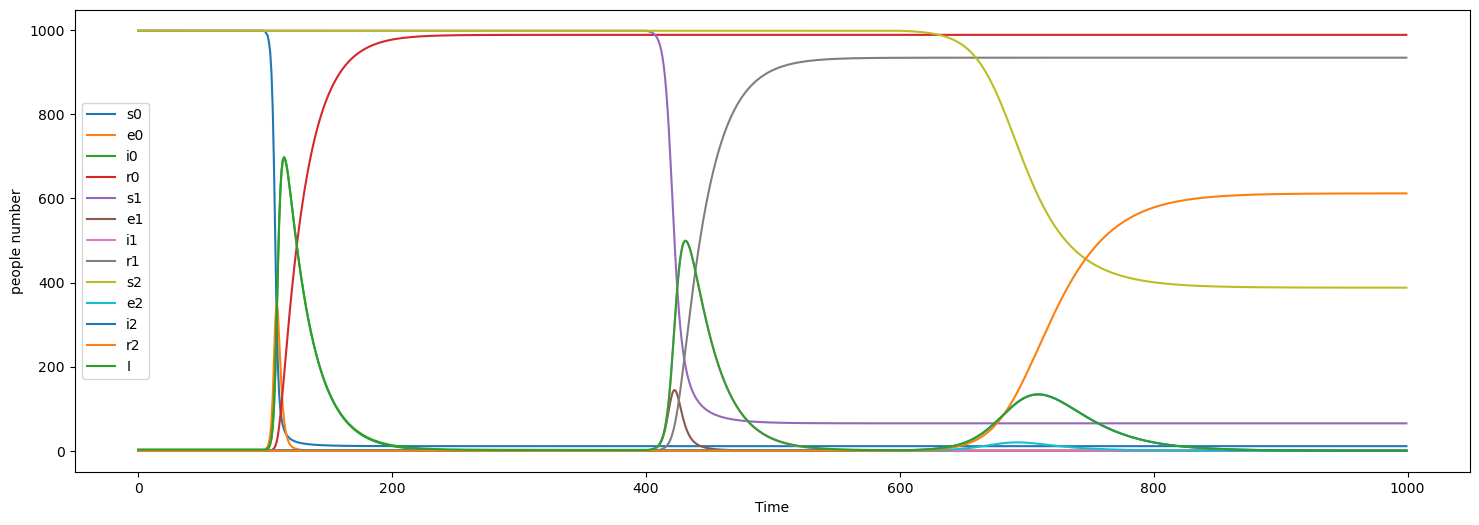

In [119]:

stateHistoryPlot0= stateHistoryPlot[:, 0, :]
stateHistoryPlot1= stateHistoryPlot[:, 1, :]
stateHistoryPlot2= stateHistoryPlot[:, 2, :]
print(statisticI.shape)
plt.figure(figsize=(18,6))
plt.plot(stateHistoryPlot0, label=["s0", "e0", "i0", "r0"])
plt.plot(stateHistoryPlot1, label=["s1", "e1", "i1", "r1"])
plt.plot(stateHistoryPlot2, label=["s2", "e2", "i2", "r2"])
# for i, _ in enumerate(staticSI):
#     staticSI[i]= i*staticSI[i]
plt.plot(staticSI, label="I")
print(len(staticSI))
plt.xlabel("Time")
#plt.ylabel("Infectiveness number")
plt.ylabel("people number")
plt.legend()

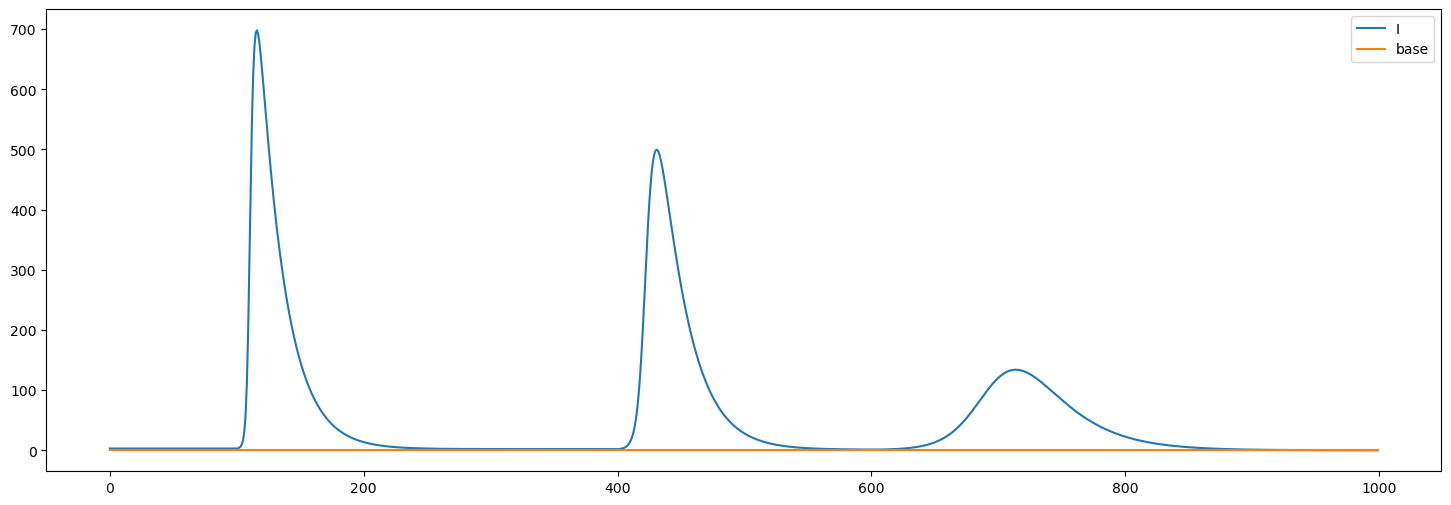

In [83]:
plt.figure(figsize=(18,6))
plt.plot(staticSI, label="I")
plt.plot([1.001]*1000, label="base")
plt.legend()

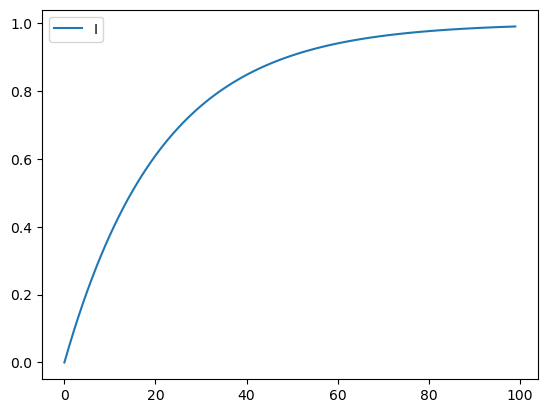

In [14]:
ys= []
for i in range(100):
    y= 1-0.954**i
    ys.append(y)
plt.plot(ys, label="I")
plt.legend()